In [118]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from sensor_projection_utils import *
from datetime import  datetime
import os
import matplotlib.pyplot as plt

In [2]:
def draw_circle_on_frame(video_path, df_users,timestamp):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    a = 0
    
    # Check if the video is opened successfully
    if not video.isOpened():
        print("Error: Could not open video.")
        return
    
    # Calculate the frame number corresponding to the timestamp
    frame_rate = video.get(cv2.CAP_PROP_FPS)
    target_frame_number = int(timestamp * frame_rate)
    
    # Set the video capture object to the target frame number
    video.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number)
    
    # Read the frame
    ret, frame = video.read()
    
    # Check if the frame is read successfully
    if not ret:
        print("Error: Could not read frame.")
        return
    
    
    # Get the resolution of the opened frame
    resolution = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    print(f'resolution is {resolution} , fps is = {frame_rate}')
    for index, row in df_users.iterrows():
        #q = [row['UnitQuaternion.x'] ,row['UnitQuaternion.y'],row['UnitQuaternion.z'],row['UnitQuaternion.w']]
        #pos = [row['HmdPosition.x'], row['HmdPosition.y'] , row['HmdPosition.z']]
        #x,y = project_point(q,pos,resolution[0],resolution[1])
        
      
        q = [ row['UnitQuaternion.w'],row['UnitQuaternion.x'], row['UnitQuaternion.y'], row['UnitQuaternion.z']]
        
         
        direction_vect = direction_vect_from_quaternion_in_cartesian(q)
        direction_vect_spherical = vect_cartesian_to_spherical(direction_vect)
        equirect_point_cartesian = project_spherical_vect_to_equirect_point(direction_vect_spherical)
        
        x_pixel,y_pixel = equirect_point_to_pixels(equirect_point_cartesian,resolution)
        
        
        
        # Draw a red circle on the frame at the specified point
        cv2.circle(frame, (int(x_pixel), int(y_pixel)), 15, (0, 0, 255), -1)  # Red circle with radius 5
     
        
    # Display the frame with the circle
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Frame at Timestamp {} s with Circles'.format(timestamp))
    plt.axis('off')
    plt.show()
    
    # Release the video capture object
    video.release()



In [3]:
import pandas as pd
import os

# Define the path to the folders containing CSV files
folders_path = './'
def get_users_df(timestamp,video_csv):
    df_users = pd.DataFrame()

    # Iterate through folders numbered from 1 to 48
    for folder_num in range(1, 49):
        folder_name = f"{folder_num}"  # Pad folder number with leading zeros if necessary
        folder_path = os.path.join(folders_path, folder_name)

        # Check if the folder exists
        if os.path.exists(folder_path):
            csv_file_path = os.path.join(folder_path, video_csv)

            # Check if the CSV file exists
            if os.path.exists(csv_file_path):
                # Read CSV file into a DataFrame
                df = pd.read_csv(csv_file_path)

                # Filter rows where PlaybackTime column has int value of timestamp
                filtered_df = df[df['PlaybackTime'].astype(int) == timestamp]

                # Take the first row meeting the condition
                if not filtered_df.empty:
                    first_row = filtered_df.iloc[0]
                    df_users = pd.concat([df_users, filtered_df.iloc[4:5]], ignore_index=True)
                else:
                    print(f"No row with PlaybackTime = {timestamp} found in folder {folder_name}")
            else:
                print(f"CSV file not found in folder {folder_name}")
        else:
            print(f"Folder {folder_name} not found")
    return df_users


resolution is (2880, 1440) , fps is = 29.97002997002997


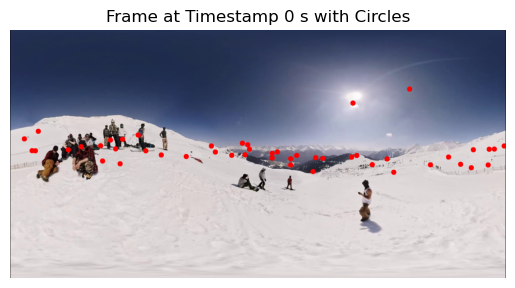

In [6]:
ts = 0
df_users = get_users_df(ts,"video_1.csv")
draw_circle_on_frame('./002.mp4',df_users,ts)

In [37]:
def draw_trajectory_user(video_path, df_user,output_filename):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    trajectory_df = pd.DataFrame(columns=['Timestamp','X', 'Y','X_pixel','Y_pixel'])
    
    # Check if the video is opened successfully
    if not video.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    frame_rate = video.get(cv2.CAP_PROP_FPS)
    resolution = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Set codec
    output_video_path = f'{output_filename}.mp4'
    out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, resolution)
    target_frame_number = 0
    
    # Process each row in df_users
    for index, row in df_user.iterrows():
        # Convert timestamp to frame number
        playback_time = row['PlaybackTime']
        if target_frame_number == int(playback_time * frame_rate):
            continue
            
        target_frame_number = int(playback_time * frame_rate)
        print(f'frame number {target_frame_number}')
        if target_frame_number == 500:
            # Release resources
            video.release()
            out.release()
            print("Video processing complete. Saved to", output_video_path)
            
        # Set video to the target frame
        video.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number)
        
        # Read the target frame
        success, frame = video.read()
        if not success:
            print(f"Error: Could not read frame at {target_frame_number}.")
            break
        
        q = [ row['UnitQuaternion.w'],row['UnitQuaternion.x'], row['UnitQuaternion.y'], row['UnitQuaternion.z']
             , row['HmdPosition.x'] , row['HmdPosition.y'] , row['HmdPosition.z']]
         
        direction_vect = direction_vect_from_quaternion_in_cartesian(q)
        direction_vect_spherical = vect_cartesian_to_spherical(direction_vect)
        equirect_point_cartesian = project_spherical_vect_to_equirect_point(direction_vect_spherical)
        x,y = equirect_point_cartesian[0],equirect_point_cartesian[1]
        x_pixel,y_pixel = equirect_point_to_pixels(equirect_point_cartesian,resolution)       
        
        
        
        
        # Draw a circle on the frame
        cv2.circle(frame, (int(x_pixel), int(y_pixel)), 15, (0, 255, 0), -1)  # Red circle with radius 15
        # Append to the DataFrame
        trajectory_df = trajectory_df.append({'Timestamp': playback_time, 'X': x, 'Y': y,
                                              'X_pixel': x_pixel,'Y_pixel':y_pixel}
                                             , ignore_index=True)
        
        # Write the modified frame into the output file
        out.write(frame)
    
    # Release resources
    video.release()
    out.release()
    print("Video processing complete. Saved to", output_video_path)
    return trajectory_df

In [ ]:
df = pd.read_csv("./1/video_2.csv")
trajectory_df = draw_trajectory_user('./002.mp4', df,'vid2-user1-direct')

In [39]:
df = df.drop(columns=['Timestamp','HmdPosition.x','HmdPosition.y','HmdPosition.z'],axis=1)

In [40]:
df

,PlaybackTime,UnitQuaternion.x,UnitQuaternion.y,UnitQuaternion.z,UnitQuaternion.w
0,0.021,-0.010,0.951,-0.011,-0.308
1,0.043,-0.011,0.951,-0.011,-0.308
2,0.064,-0.011,0.951,-0.011,-0.308
3,0.085,-0.011,0.951,-0.011,-0.308
4,0.055,-0.011,0.951,-0.011,-0.308
...,...,...,...,...,...
26267,293.196,-0.272,0.425,0.168,0.847
26268,293.196,-0.272,0.425,0.168,0.847
26269,293.217,-0.271,0.425,0.167,0.847
26270,293.217,-0.271,0.425,0.167,0.848


In [41]:
trajectory_df

,Timestamp,X,Y,X_pixel,Y_pixel
0,0.043,0.849729,0.495495,432.781074,713.512536
1,0.085,0.849729,0.495495,432.781074,713.512536
2,0.055,0.849729,0.495495,432.781074,713.512536
3,0.076,0.849729,0.495495,432.781074,713.512536
4,0.140,0.849724,0.496101,432.794895,714.384737
...,...,...,...,...,...
495,16.524,0.923598,0.481606,220.036736,693.513216
496,16.567,0.922887,0.481841,222.085726,693.851228
497,16.588,0.922178,0.481746,224.127087,693.713738
498,16.631,0.921469,0.481650,226.169184,693.576417


In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_one_dim_projection_data(video_number, users_range, start_frame, end_frame, data_type='X'):
    # Initialize a color map for different users
    user_start, user_end = users_range[0], users_range[1] + 1
    color_map = plt.cm.get_cmap('tab20', user_end - user_start + 1)
    
    # Initialize a list to store descriptive statistics
    descriptive_stats = []
    
    # Iterate through user folders
    for user_number in range(user_start, user_end):
        folder_path = f"./{user_number}/"  # Update this path
        
        # Check if folder exists
        if os.path.exists(folder_path):
            csv_path = os.path.join(folder_path, f"video_{video_number}-projection.csv")
            
            # Check if CSV file exists
            if os.path.exists(csv_path):
                # Read CSV file
                df = pd.read_csv(csv_path)
                
                # Filter dataframe based on start_frame and end_frame
                df = df[(df['Frame.No'] >= start_frame) & (df['Frame.No'] <= end_frame)]
                
                # Plot data
                plt.plot(df['Frame.No'], df[data_type], color=color_map(user_number - user_start),
                         label=f"User {user_number}")
                
                # Compute descriptive statistics
                stats = df[data_type].describe()
                descriptive_stats.append(stats)
    
    # Add labels and legend
    plt.xlabel('Frame Number')
    plt.ylabel(f'{data_type} Value')
    plt.title(f'{data_type} Values for Video {video_number} between Frames {start_frame} and {end_frame}')
    plt.legend()
    
    # Show plot
    plt.show()
    
    # Display descriptive statistics
    stats_df = pd.concat(descriptive_stats, axis=1)
    stats_df.columns = [f'User {i}' for i in range(user_start, user_end)]
    print("Descriptive Statistics:")
    print(stats_df)




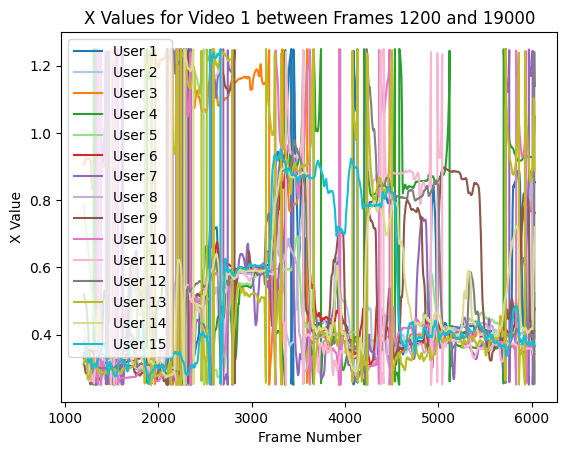

Descriptive Statistics:
            User 1       User 2       User 3       User 4       User 5  \
count  7276.000000  7281.000000  7276.000000  7276.000000  7277.000000   
mean      0.516506     0.456808     0.631371     0.595181     0.441706   
std       0.225553     0.103556     0.337589     0.276161     0.161058   
min       0.250307     0.272045     0.250624     0.250043     0.250191   
25%       0.332232     0.387830     0.375381     0.361638     0.364006   
50%       0.427618     0.415116     0.398792     0.505896     0.406378   
75%       0.606087     0.524424     1.022901     0.855484     0.461107   
max       1.249582     0.887739     1.249927     1.249943     1.249359   

            User 6       User 7       User 8       User 9      User 10  \
count  7238.000000  7277.000000  7271.000000  7276.000000  7274.000000   
mean      0.470879     0.505715     0.438832     0.553895     0.487698   
std       0.157073     0.274856     0.146549     0.248206     0.259645   
min       0.2

In [39]:

# Example usage:
plot_one_dim_projection_data(1,[1,15], 1200,19000,'X')


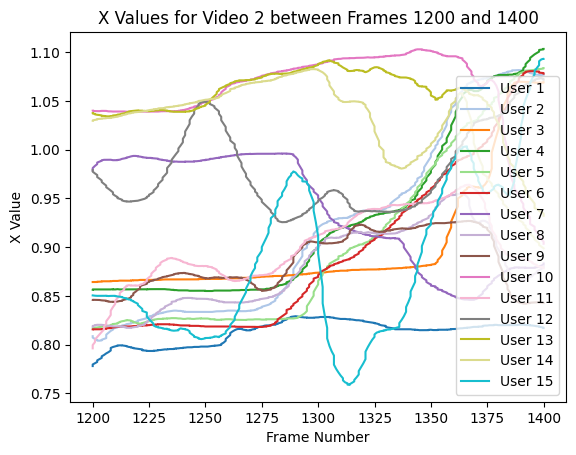

Descriptive Statistics:
           User 1      User 2      User 3      User 4      User 5      User 6  \
count  300.000000  299.000000  300.000000  299.000000  300.000000  299.000000   
mean     0.812875    0.921047    0.901767    0.928090    0.903381    0.895439   
std      0.012265    0.095077    0.062428    0.084123    0.091674    0.085601   
min      0.778096    0.804119    0.864306    0.855089    0.816697    0.815796   
25%      0.798908    0.834263    0.867388    0.856705    0.826107    0.819271   
50%      0.816510    0.918414    0.873821    0.901419    0.863660    0.871492   
75%      0.820447    0.994365    0.882158    0.977898    0.981172    0.959573   
max      0.829213    1.081753    1.069780    1.103448    1.083649    1.080625   

           User 7      User 8      User 9     User 10     User 11     User 12  \
count  300.000000  301.000000  299.000000  300.000000  301.000000  301.000000   
mean     0.937857    0.878394    0.885519    1.060122    0.900140    0.979648   
std

In [40]:

# Example usage:
plot_one_dim_projection_data(2,[1,15], 1200,1400,'X')

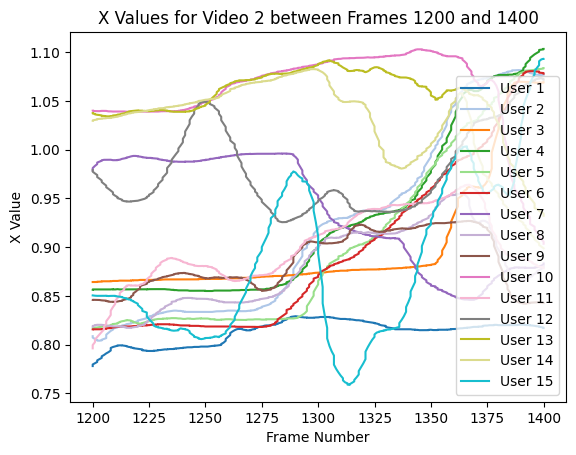

Descriptive Statistics:
           User 1      User 2      User 3      User 4      User 5      User 6  \
count  300.000000  299.000000  300.000000  299.000000  300.000000  299.000000   
mean     0.812875    0.921047    0.901767    0.928090    0.903381    0.895439   
std      0.012265    0.095077    0.062428    0.084123    0.091674    0.085601   
min      0.778096    0.804119    0.864306    0.855089    0.816697    0.815796   
25%      0.798908    0.834263    0.867388    0.856705    0.826107    0.819271   
50%      0.816510    0.918414    0.873821    0.901419    0.863660    0.871492   
75%      0.820447    0.994365    0.882158    0.977898    0.981172    0.959573   
max      0.829213    1.081753    1.069780    1.103448    1.083649    1.080625   

           User 7      User 8      User 9     User 10     User 11     User 12  \
count  300.000000  301.000000  299.000000  300.000000  301.000000  301.000000   
mean     0.937857    0.878394    0.885519    1.060122    0.900140    0.979648   
std

In [102]:

# Example usage:
plot_one_dim_projection_data(2,[1,15], 1200,1400,'X')


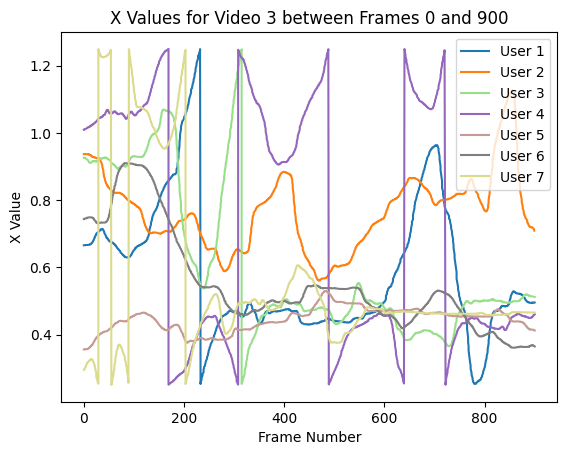

In [26]:

# Example usage:
plot_one_dim_projection_data(3,[1,7], 0, 900,'X')

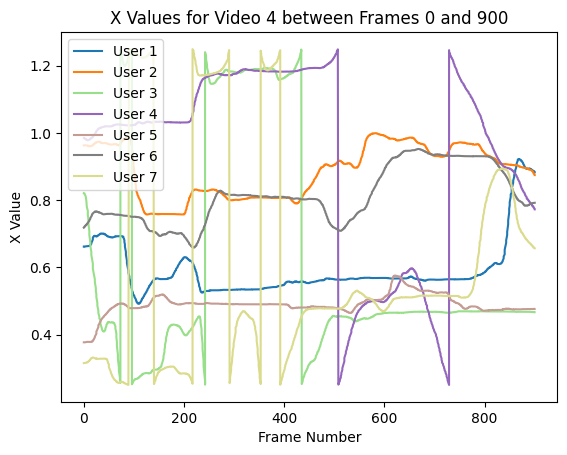

In [28]:

# Example usage:
plot_one_dim_projection_data(4,[1,7], 0, 900,'X')

In [43]:
def plot_two_dim_projection_data(video_number, users_range, start_frame, end_frame, data_type1='X', data_type2='Y'):
    user_start, user_end = users_range[0], users_range[1] + 1
    color_map = plt.cm.get_cmap('tab20', user_end - user_start + 1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for user_number in range(user_start, user_end):
        folder_path = f"./{user_number}/"  # Update this path
        
        if os.path.exists(folder_path):
            csv_path = os.path.join(folder_path, f"video_{video_number}-projection.csv")
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                df = df[(df['Frame.No'] >= start_frame) & (df['Frame.No'] <= end_frame)]
                ax.plot(df['Frame.No'], df[data_type1], df[data_type2], color=color_map(user_number - user_start),
                        label=f"User {user_number}")

    ax.set_xlabel('Frame Number')
    ax.set_ylabel(f'{data_type1} Value')
    ax.set_zlabel(f'{data_type2} Value')
    ax.set_title(f'{data_type1} vs {data_type2} Values for Video {video_number} between Frames {start_frame} and {end_frame}')
    ax.legend()
    
    plt.show()

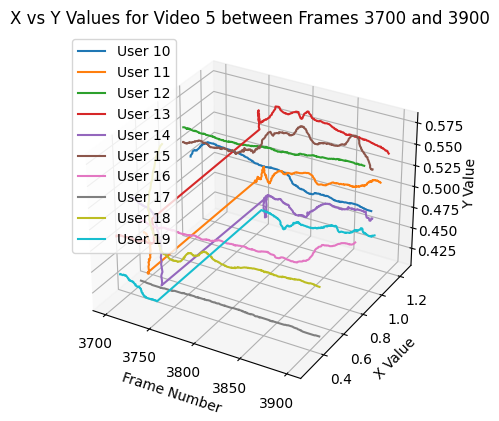

In [58]:
plot_two_dim_projection_data(5, (10, 19), 3700,3900, data_type1='X', data_type2='Y')